Лабораторная работа 4

Тема: Линейные классификаторы

Вариант 6 (датасет flight_delays)

Построить линейную дискриминантную функцию Фишера для классификации на два класса. Разбивку на классы сделать  по столбцу "правильных ответов". Если этот столбец непонятно как определить (можно спросить о нем у преподавателя), то использовать  разбиение на 2 кластера в задании 2 или 3. Классификацию проводить по всем признакам, а для визуализации использовать два наиболее значимых или главные компоненты из 3.
Методом главных компонент построить два новых признака для описания объектов из датасета задания 2 и кластеризовать данные по этим двум признакам на два кластера (любым методом). Сравнить качество кластеризации  из задания 2 и из этого задания.

Accuracy: 0.79164 
Recall: 0.21212121212121213 
Precision: 0.03214360258818618 
Specificity: 0.8089725632363846 
Fall-out: 0.1910274367636154 
F-1: 0.055827442450607216


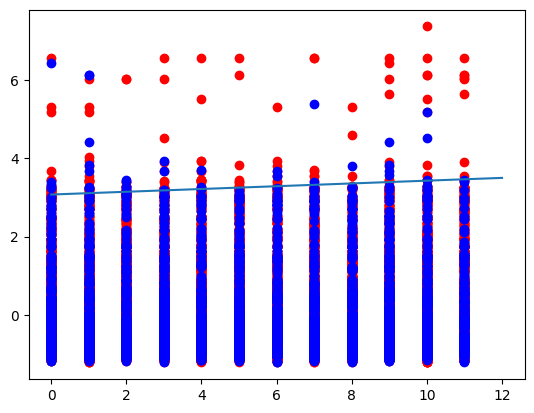

In [134]:
import pandas as pd
import numpy as np
import datetime
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

def lda():
  df = pd.read_csv('flight_delays.csv', sep=',')
  cats = ["Month","DayofMonth","DayOfWeek", "UniqueCarrier","Origin","Dest","dep_delayed_15min"]

  train = df[::2].copy()
  check = df[1::2].copy()

  for cat in cats:
    train[f'{cat}_cat'] = pd.factorize(train[cat], sort=True)[0]
    check[f'{cat}_cat'] = pd.factorize(check[cat], sort=True)[0]

  # Выбираем категориальные и числовые данные
  numer = train[["DepTime","Distance"]]
  cater = train[[f"{cat}_cat" for cat in cats]]
  numer_check = check[["DepTime","Distance"]]
  cater_check = check[[f"{cat}_cat" for cat in cats]]

  # Подготавливаем числовые данные
  numer = pd.DataFrame(StandardScaler().fit_transform(numer))
  numer.columns = ["DepTime_Scaled", "Distance_Scaled"]
  numer_check = pd.DataFrame(StandardScaler().fit_transform(numer_check))
  numer_check.columns = ["DepTime_Scaled", "Distance_Scaled"]

  # Сливаем подготовленные данные в новый датасет
  Df = pd.concat([numer, cater], axis=1, join='inner')
  Df_check = pd.concat([numer_check, cater_check], axis=1, join='inner')

  # Просчёт весов и порога
  A = Df.drop("dep_delayed_15min_cat", axis=1).cov()
  Df1 = Df[Df["dep_delayed_15min_cat"] == 0].drop("dep_delayed_15min_cat", axis=1)
  Df2 = Df[Df["dep_delayed_15min_cat"] == 1].drop("dep_delayed_15min_cat", axis=1)
  A_inv = np.linalg.inv(A)
  m_1 = Df1.mean()
  m_2 = Df2.mean()
  coef_discr_func = A_inv.dot(m_1 - m_2)
  porog = coef_discr_func.dot((m_1 + m_2) / 2)

  # Просчёт попаданий и промахов
  TP = 0
  TN = 0
  FP = 0
  FN = 0

  for i in range(0, len(Df_check)):
    X = Df_check.iloc[[i]].drop("dep_delayed_15min_cat", axis=1)

    prediction = sum((coef_discr_func * X).to_numpy()[0]) + porog
    if prediction > 0:
      pred_class = 0
    else:
      pred_class = 1

    if pred_class == Df_check.iloc[[i]]["dep_delayed_15min_cat"].item():
      if pred_class:
        TP += 1
      else:
        TN += 1
    else:
      if pred_class:
        FN += 1
      else:
        FP += 1

  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  Fmetrics = 2 * (precision * recall) / (precision + recall)

  print("Accuracy:", (TP + TN) / (TP + TN + FP + FN),
        "\nRecall:", TP / (TP + FN),
        "\nPrecision:", TP / (TP + FP),
        "\nSpecificity:", TN / (FP + TN),
        "\nFall-out:", FP / (FP + TN),
        "\nF-1:", Fmetrics)

  y_index = 1
  x_index = 2

  plt.scatter(
        x = Df1[Df1.columns[x_index]],
        y = Df1[Df1.columns[y_index]],
        c = "red",
    )

  plt.scatter(
        x = Df2[Df2.columns[x_index]],
        y = Df2[Df2.columns[y_index]],
        c = "blue",
    )

  x = np.arange(-1, .3, 0.1)

  plt.plot(
      -coef_discr_func[x_index] / coef_discr_func[y_index] * x - porog / coef_discr_func[y_index]
  )

  plt.show()

lda()

Вывод: полученный классификатор, несмотря на неплохой показатель Accuracy, довольно плохо справляется с предсказанием результата задержки, так как более важные параметры F-1, Recall и Precision говорят о том, что классификатор плохо справляется с задачей нахождений конкретных случаев, неверно относит полёты. Задача плохо поддаётся классификации, и какую либо строгую закономерность выделить не получается. Одну из закономерностей, которую можно выделить, это то что рейсы, которые отправляется в дальний полёт (большой показатель времени полёта) имеют меньшее количество задержек.